Model From https://github.com/fxia22/pointnet.pytorch/blob/master/pointnet/model.py

In [1]:
!git clone https://github.com/weidezhang/pypcd_python3.6.git pypcd_hack

In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.utils.data
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F

https://github.com/meder411/PointNet-PyTorch/blob/master/models/transformer.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as grad


class TransformationNet(nn.Module):

    def __init__(self, input_dim, output_dim):
        super(TransformationNet, self).__init__()
        self.output_dim = output_dim

        self.conv_1 = nn.Conv1d(input_dim, 32, 1)
        self.conv_2 = nn.Conv1d(32, 16, 1)
        self.conv_3 = nn.Conv1d(16, 8, 1)

        self.bn_1 = nn.BatchNorm1d(32)
        self.bn_2 = nn.BatchNorm1d(16)
        self.bn_3 = nn.BatchNorm1d(8)
        self.bn_4 = nn.BatchNorm1d(4)
        self.bn_5 = nn.BatchNorm1d(2)

        self.fc_1 = nn.Linear(8,4)
        self.fc_2 = nn.Linear(4, 2)
        self.fc_3 = nn.Linear(2, self.output_dim*self.output_dim)

    def forward(self, x):
        num_points = x.shape[1]
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = F.relu(self.bn_3(self.conv_3(x)))

        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, 8)

        x = F.relu(self.bn_4(self.fc_1(x)))
        x = F.relu(self.bn_5(self.fc_2(x)))
        x = self.fc_3(x)

        identity_matrix = torch.eye(self.output_dim)
        if torch.cuda.is_available():
            identity_matrix = identity_matrix.cuda()
        x = x.view(-1, self.output_dim, self.output_dim) + identity_matrix
        return x


In [4]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv("/media/person_data.csv")
df.head()

,OriginalID,Stamp,LabeledId,MeanX,MreanY,MeanZ,MeanI,VarX,VarY,VarZ,VarI,RangeX,RangeY,RangeZ,RangeI,SafetyIndex
0,person_BGV160,1.593697e+18,person_CHW026,2.16070,-1.51747,0.009536,25.7358,0.017539,0.008052,0.070805,161.762,0.580519,0.501747,0.962191,53,691.907
1,person_BGV160,1.593697e+18,person_CHW026,2.10568,-1.42697,0.000821,26.6586,0.016780,0.010158,0.067378,157.341,0.549305,0.558436,0.929846,53,691.907
2,person_BGV160,1.593697e+18,person_CHW026,2.04742,-1.34319,0.001883,25.0231,0.031696,0.012176,0.077002,185.470,1.073560,0.886896,1.049920,53,691.907
3,person_BGV160,1.593697e+18,person_CHW026,2.03730,-1.27878,0.030707,25.9707,0.024252,0.008819,0.073974,148.507,1.022480,0.517114,1.006430,52,691.907
4,person_BGV160,1.593697e+18,person_CHW026,2.00939,-1.23015,0.018220,26.5070,0.022890,0.009475,0.086418,155.662,0.981035,0.661598,1.103300,53,1251.220


In [6]:
df = df.loc[:,["OriginalID","Stamp", "SafetyIndex"]]

In [7]:
df["Stamp"] = df["Stamp"].round().astype(np.uint64)
df

,OriginalID,Stamp,SafetyIndex
0,person_BGV160,1593697069265969920,691.907
1,person_BGV160,1593697069651310080,691.907
2,person_BGV160,1593697070272859904,691.907
3,person_BGV160,1593697070662200064,691.907
4,person_BGV160,1593697071273590016,1251.220
...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240
2320,person_ZGH580,1593792747544580096,1200.240
2321,person_ZGH580,1593792756543450112,1200.240
2322,person_ZGH580,1593792756743529984,1200.240


In [8]:
df["FStamp"] = df["Stamp"].floordiv(1000000)
df

,OriginalID,Stamp,SafetyIndex,FStamp
0,person_BGV160,1593697069265969920,691.907,1593697069265
1,person_BGV160,1593697069651310080,691.907,1593697069651
2,person_BGV160,1593697070272859904,691.907,1593697070272
3,person_BGV160,1593697070662200064,691.907,1593697070662
4,person_BGV160,1593697071273590016,1251.220,1593697071273
...,...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240,1593792746947
2320,person_ZGH580,1593792747544580096,1200.240,1593792747544
2321,person_ZGH580,1593792756543450112,1200.240,1593792756543
2322,person_ZGH580,1593792756743529984,1200.240,1593792756743


In [9]:
import os


def find_file(folder, needle):
    directory = os.listdir(folder)
    for fname in directory:
        if needle in fname:
            #print('found string in file %s' % fname)
            return folder+fname
    return None

In [10]:
import os
PATH = "/media/datasets/persons_pcd/"

df['needle'] = df.OriginalID.str.cat("*"+df.FStamp.astype(str))
df
#batch = df.iloc[[0,100]]
#print (batch["OriginalID"].tolist()  batch["Stamp"].tolist())
#files = os.path.join(PATH, (batch["OriginalID"]+str(batch["Stamp"])).to_string())

#files


,OriginalID,Stamp,SafetyIndex,FStamp,needle
0,person_BGV160,1593697069265969920,691.907,1593697069265,person_BGV160*1593697069265
1,person_BGV160,1593697069651310080,691.907,1593697069651,person_BGV160*1593697069651
2,person_BGV160,1593697070272859904,691.907,1593697070272,person_BGV160*1593697070272
3,person_BGV160,1593697070662200064,691.907,1593697070662,person_BGV160*1593697070662
4,person_BGV160,1593697071273590016,1251.220,1593697071273,person_BGV160*1593697071273
...,...,...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240,1593792746947,person_ZGH580*1593792746947
2320,person_ZGH580,1593792747544580096,1200.240,1593792747544,person_ZGH580*1593792747544
2321,person_ZGH580,1593792756543450112,1200.240,1593792756543,person_ZGH580*1593792756543
2322,person_ZGH580,1593792756743529984,1200.240,1593792756743,person_ZGH580*1593792756743


In [11]:
df['class'], df['id'] = df['OriginalID'].str.split('_', 1).str
df

,OriginalID,Stamp,SafetyIndex,FStamp,needle,class,id
0,person_BGV160,1593697069265969920,691.907,1593697069265,person_BGV160*1593697069265,person,BGV160
1,person_BGV160,1593697069651310080,691.907,1593697069651,person_BGV160*1593697069651,person,BGV160
2,person_BGV160,1593697070272859904,691.907,1593697070272,person_BGV160*1593697070272,person,BGV160
3,person_BGV160,1593697070662200064,691.907,1593697070662,person_BGV160*1593697070662,person,BGV160
4,person_BGV160,1593697071273590016,1251.220,1593697071273,person_BGV160*1593697071273,person,BGV160
...,...,...,...,...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240,1593792746947,person_ZGH580*1593792746947,person,ZGH580
2320,person_ZGH580,1593792747544580096,1200.240,1593792747544,person_ZGH580*1593792747544,person,ZGH580
2321,person_ZGH580,1593792756543450112,1200.240,1593792756543,person_ZGH580*1593792756543,person,ZGH580
2322,person_ZGH580,1593792756743529984,1200.240,1593792756743,person_ZGH580*1593792756743,person,ZGH580


In [12]:
df["path"] = PATH + df["id"] + "/"
df

,OriginalID,Stamp,SafetyIndex,FStamp,needle,class,id,path
0,person_BGV160,1593697069265969920,691.907,1593697069265,person_BGV160*1593697069265,person,BGV160,/media/datasets/persons_pcd/BGV160/
1,person_BGV160,1593697069651310080,691.907,1593697069651,person_BGV160*1593697069651,person,BGV160,/media/datasets/persons_pcd/BGV160/
2,person_BGV160,1593697070272859904,691.907,1593697070272,person_BGV160*1593697070272,person,BGV160,/media/datasets/persons_pcd/BGV160/
3,person_BGV160,1593697070662200064,691.907,1593697070662,person_BGV160*1593697070662,person,BGV160,/media/datasets/persons_pcd/BGV160/
4,person_BGV160,1593697071273590016,1251.220,1593697071273,person_BGV160*1593697071273,person,BGV160,/media/datasets/persons_pcd/BGV160/
...,...,...,...,...,...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240,1593792746947,person_ZGH580*1593792746947,person,ZGH580,/media/datasets/persons_pcd/ZGH580/
2320,person_ZGH580,1593792747544580096,1200.240,1593792747544,person_ZGH580*1593792747544,person,ZGH580,/media/datasets/persons_pcd/ZGH580/
2321,person_ZGH580,1593792756543450112,1200.240,1593792756543,person_ZGH580*1593792756543,person,ZGH580,/media/datasets/persons_pcd/ZGH580/
2322,person_ZGH580,1593792756743529984,1200.240,1593792756743,person_ZGH580*1593792756743,person,ZGH580,/media/datasets/persons_pcd/ZGH580/


In [13]:
df["filenames"] = df.apply(lambda row: find_file(row.path, row.needle), axis=1)
df

,OriginalID,Stamp,SafetyIndex,FStamp,needle,class,id,path,filenames
0,person_BGV160,1593697069265969920,691.907,1593697069265,person_BGV160*1593697069265,person,BGV160,/media/datasets/persons_pcd/BGV160/,/media/datasets/persons_pcd/BGV160/person_BGV1...
1,person_BGV160,1593697069651310080,691.907,1593697069651,person_BGV160*1593697069651,person,BGV160,/media/datasets/persons_pcd/BGV160/,/media/datasets/persons_pcd/BGV160/person_BGV1...
2,person_BGV160,1593697070272859904,691.907,1593697070272,person_BGV160*1593697070272,person,BGV160,/media/datasets/persons_pcd/BGV160/,/media/datasets/persons_pcd/BGV160/person_BGV1...
3,person_BGV160,1593697070662200064,691.907,1593697070662,person_BGV160*1593697070662,person,BGV160,/media/datasets/persons_pcd/BGV160/,/media/datasets/persons_pcd/BGV160/person_BGV1...
4,person_BGV160,1593697071273590016,1251.220,1593697071273,person_BGV160*1593697071273,person,BGV160,/media/datasets/persons_pcd/BGV160/,/media/datasets/persons_pcd/BGV160/person_BGV1...
...,...,...,...,...,...,...,...,...,...
2319,person_ZGH580,1593792746947930112,1200.240,1593792746947,person_ZGH580*1593792746947,person,ZGH580,/media/datasets/persons_pcd/ZGH580/,/media/datasets/persons_pcd/ZGH580/person_ZGH5...
2320,person_ZGH580,1593792747544580096,1200.240,1593792747544,person_ZGH580*1593792747544,person,ZGH580,/media/datasets/persons_pcd/ZGH580/,/media/datasets/persons_pcd/ZGH580/person_ZGH5...
2321,person_ZGH580,1593792756543450112,1200.240,1593792756543,person_ZGH580*1593792756543,person,ZGH580,/media/datasets/persons_pcd/ZGH580/,/media/datasets/persons_pcd/ZGH580/person_ZGH5...
2322,person_ZGH580,1593792756743529984,1200.240,1593792756743,person_ZGH580*1593792756743,person,ZGH580,/media/datasets/persons_pcd/ZGH580/,/media/datasets/persons_pcd/ZGH580/person_ZGH5...


In [14]:
np.unique(df["SafetyIndex"].values, return_counts=True)

(array([0.00000e+00, 6.05690e-03, 2.42276e-02, 3.83571e-01, 2.17026e+00,
        2.24004e+00, 2.41109e+00, 2.42465e+00, 2.49736e+00, 2.82150e+00,
        3.62997e+00, 1.76754e+01, 1.85194e+01, 1.97495e+01, 2.02458e+01,
        2.04477e+01, 2.27459e+01, 3.01537e+01, 3.21452e+01, 3.83781e+01,
        4.60004e+01, 5.79397e+01, 6.23616e+01, 6.31954e+01, 7.31288e+01,
        7.37274e+01, 7.37491e+01, 7.40555e+01, 7.60848e+01, 1.66124e+02,
        1.99145e+02, 2.01002e+02, 2.83591e+02, 2.89801e+02, 2.93714e+02,
        3.61573e+02, 3.62935e+02, 3.63803e+02, 3.64285e+02, 3.66205e+02,
        3.67562e+02, 3.69910e+02, 3.71218e+02, 3.72666e+02, 3.75700e+02,
        3.81705e+02, 3.83515e+02, 3.85435e+02, 3.88853e+02, 3.90007e+02,
        3.92534e+02, 3.92999e+02, 3.93242e+02, 3.95942e+02, 4.00593e+02,
        4.04895e+02, 4.05247e+02, 4.07678e+02, 4.19128e+02, 4.46096e+02,
        4.48970e+02, 4.54421e+02, 5.34755e+02, 6.52831e+02, 6.70929e+02,
        6.91907e+02, 7.40116e+02, 8.43323e+02, 9.31

In [15]:
#not so sure of this line
#df["SafetyIndex"] = df["SafetyIndex"].apply(lambda x: x+ np.random.rand())
nmax = df["SafetyIndex"].max()
df["SafetyIndex"] = df["SafetyIndex"].apply(lambda x: x/nmax)


In [16]:
np.unique(df["SafetyIndex"].values, return_counts=True)

(array([0.00000000e+00, 3.71677886e-06, 1.48671154e-05, 2.35375949e-04,
        1.33176650e-03, 1.37458656e-03, 1.47955032e-03, 1.48787133e-03,
        1.53248937e-03, 1.73139586e-03, 2.22750842e-03, 1.08463988e-02,
        1.13643142e-02, 1.21191573e-02, 1.24237087e-02, 1.25476034e-02,
        1.39578795e-02, 1.85036297e-02, 1.97257012e-02, 2.35504814e-02,
        2.82278582e-02, 3.55543351e-02, 3.82678064e-02, 3.87794626e-02,
        4.48750314e-02, 4.52423586e-02, 4.52556747e-02, 4.54436951e-02,
        4.66889624e-02, 1.01940955e-01, 1.22204086e-01, 1.23343622e-01,
        1.74023846e-01, 1.77834574e-01, 1.80235762e-01, 2.21877014e-01,
        2.22712796e-01, 2.23245439e-01, 2.23541215e-01, 2.24719411e-01,
        2.25552126e-01, 2.26992962e-01, 2.27795608e-01, 2.28684164e-01,
        2.30545959e-01, 2.34230890e-01, 2.35341585e-01, 2.36519781e-01,
        2.38617215e-01, 2.39325360e-01, 2.40876038e-01, 2.41161382e-01,
        2.41310498e-01, 2.42967336e-01, 2.45821393e-01, 2.484612

In [17]:
data = df[['filenames', 'SafetyIndex']].copy()
del df

In [18]:
data = data.dropna()

In [19]:
def get_batchfilenames_from_data(start_index, end_index):
    batch = data.iloc[start_index:end_index,:]
    return batch.filenames.tolist(), batch.SafetyIndex.tolist()

def get_filename_from_data(index):
    batch = data.iloc[index,:]
    return batch.filenames, batch.SafetyIndex
get_filename_from_data(1)[1].shape

()

In [20]:
def get_number_of_samples():
    return len(data)

In [21]:
from pypcd_hack.pypcd import point_cloud_from_path

In [22]:
def get_labeled_batch(start_index, end_index):
    print("FUNCTION LABELED BATCH NOT FINISHED")
    batch, labels = get_batchfilenames_from_data(start_index,end_index)
    pcs = list()
    for b,l in zip(batch,labels):
        pc = point_cloud_from_path(b)
        pc = np.asarray(pc.pc_data)  
        pcs.append(pc)
    return (pcs, labels)

def get_labeled_tuple(index,nsamples):
    filename, label = get_filename_from_data(index)        
    pc = point_cloud_from_path(filename)
    pc_array = np.zeros((pc.pc_data.shape[0],4),dtype=np.double)
    pc_array[:,0] = pc.pc_data['x']
    pc_array[:,1] = pc.pc_data['y']
    pc_array[:,2] = pc.pc_data['z']
    pc_array[:,3] = pc.pc_data['intensity']

    pc_array = np.resize(pc_array,(nsamples,4))

    #pc = np.asarray(pc.pc_data, np.float32)
    return (pc_array, label)

p,l = get_labeled_tuple(5,2)
p

array([[ 2.35642433, -1.1138767 , -0.32002893,  1.        ],
       [ 2.33509183, -1.12531006, -0.22677925,  6.        ]])

In [88]:
#TODO
import random
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, path="", pointsnumber=1000, index_offset = 0, factor = 1.0):
        #how many pointclouds
        self.nsamples = int(factor*get_number_of_samples())
        self.index_offset = index_offset
        self.pointsnumber = pointsnumber
        self.factor = factor
        print ("SAMPLES IN DATASET {} with offset {}".format(int(self.factor*self.nsamples),index_offset))

    def __getitem__(self,index):
        #x = np.zeros((3, self.nsamples), dtype=np.double)
        #y = random.random()
        x,y = get_labeled_tuple(index+self.index_offset, self.pointsnumber)
        
        #x = x[:self.pointsnumber]
        #normalizing x,y,z
        x[:,0] = (x[:,0]+10)/20.
        x[:,1] = (x[:,1]+10)/20.
        x[:,2] = (x[:,2]+2)/4.
        x[:,3] = (x[:,3])/255.

        
        #I THinks this should match torch shape
        #x = np.moveaxis(x,0,1)
        return (x,y)
    
    def __len__(self):
        return int(self.factor*self.nsamples)

In [69]:
class WrappedDataLoader:
    def __init__(self, dl,nsamples):
        self.dl = dl
        self.func = self.tocuda
        self.batchsize = len(self.dl)
        self.nsamples = nsamples
    
    def tocuda(self,x,y):
        return x.cuda(), y.cuda()

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [70]:
#OR train_ds = TensorDataset(x_train, y_train)

def get_data(train_ds, valid_ds, bs, nsamples):
    return (
        WrappedDataLoader(DataLoader(train_ds, batch_size=bs, shuffle=True), nsamples),
        WrappedDataLoader(DataLoader(valid_ds, batch_size=bs, shuffle=True), nsamples),
    )

#gen = DataLoader(TensorDataset(data, labels), batch_size=25, shuffle=True)


https://www.qwertee.io/blog/deep-learning-with-point-clouds/

In [71]:
class BasePointNet(nn.Module):

    def __init__(self, point_dimension, return_local_features=False, fn = 8):
        super(BasePointNet, self).__init__()
        self.return_local_features = return_local_features
        self.input_transform = TransformationNet(input_dim=point_dimension, output_dim=point_dimension)
        self.feature_transform = TransformationNet(input_dim=8, output_dim=8)

        self.conv_1 = nn.Conv1d(point_dimension, 16, 1)
        self.conv_2 = nn.Conv1d(16, 8, 1)
        self.conv_3 = nn.Conv1d(8, 4, 1)
        self.conv_4 = nn.Conv1d(4, 2, 1)
        self.conv_5 = nn.Conv1d(2, 1, 1)

        self.bn_1 = nn.BatchNorm1d(16)
        self.bn_2 = nn.BatchNorm1d(8)
        self.bn_3 = nn.BatchNorm1d(4)
        self.bn_4 = nn.BatchNorm1d(2)
        self.bn_5 = nn.BatchNorm1d(1)
        self.fn = 1

    def forward(self, x):
        num_points = x.shape[1]

        input_transform = self.input_transform(x)

        x = torch.bmm(x, input_transform)
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = x.transpose(2, 1)

        feature_transform = self.feature_transform(x)

        x = torch.bmm(x, feature_transform)
        local_point_features = x

        x = x.transpose(2, 1)
        x = F.relu(self.bn_3(self.conv_3(x)))
        x = F.relu(self.bn_4(self.conv_4(x)))
        x = F.relu(self.bn_5(self.conv_5(x)))
        x = nn.MaxPool1d(num_points)(x)
        x = x.view(-1, self.fn)

        if self.return_local_features:
            x = x.view(-1, self.fn, 1).repeat(1, 1, num_points)
            return torch.cat([x.transpose(2, 1), local_point_features], 2), feature_transform
        else:
            return x, feature_transform

In [72]:

class SegmentationPointNet(nn.Module):

    def __init__(self, point_dimension=3,npoints=200):
        super(SegmentationPointNet, self).__init__()
        self.base_pointnet = BasePointNet(return_local_features=True, point_dimension=point_dimension)

        self.conv_1 = nn.Conv1d(9, 8, 1)
        self.conv_2 = nn.Conv1d(8, 16, 1)
        self.conv_3 = nn.Conv1d(16, 8, 1)
        self.conv_4 = nn.Conv1d(8, 1, 1)

        self.bn_1 = nn.BatchNorm1d(8)
        self.bn_2 = nn.BatchNorm1d(16)
        self.bn_3 = nn.BatchNorm1d(8)
        
        self.fc1 = nn.Linear(npoints,int(npoints/2))
        self.fc2 = nn.Linear(int(npoints/2),1)

    def forward(self, x):
        x, feature_transform = self.base_pointnet(x)
        x = x.transpose(2, 1)
        x = F.relu(self.bn_1(self.conv_1(x)))
        x = F.relu(self.bn_2(self.conv_2(x)))
        x = F.relu(self.bn_3(self.conv_3(x)))

        x = self.conv_4(x)
        x = x.transpose(2, 1)
        
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.view(-1)#, feature_transform

In [73]:
def trainbatch(model,x,targets,criterion,optimizer,batchid, loss, batch_loss):
        #x = x.transpose(2, 1)
        optimizer.zero_grad()
        output = model(x)
        
        loss = criterion(output,targets)
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())

        if batchid %20 == 0:
            print("Batch {} - batch loss: {}".format(batchid, loss.item()))
        return loss.item()

In [74]:
def mytrain(model,traindata,valdata,nepochs=5,valsamples=10, device="cuda"):
    epoch_loss = list()
    batch_loss = list()

    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.2)

    model.train()

    for epoch in range(nepochs):

        loss = 0.0

        #batches number
        for b,x in enumerate(traindata):
            loss += trainbatch(model,x[0].float(),x[1].float(),criterion, optimizer,b, loss, batch_loss)
            if b == -1:
                print('interrupting for testing')
                break

        loss /= b

        print("Epoch {} - epoch loss: {}".format(epoch, loss), end=" ")
        epoch_loss.append(loss)

        #validation
        model.eval()
        with torch.no_grad():
            valid_loss = sum(criterion(model(xb.float()), yb.float()) for xb, yb in valdata)
        print(" validation loss {}".format(valid_loss/valdata.nsamples), sep="..")
    return epoch_loss, batch_loss

In [75]:
def mypredict(model,x):
    with torch.no_grad():
        return model(x)

In [171]:
pointsnumber = 250
batchsize = 5

In [172]:
mymodel = SegmentationPointNet(4, npoints=pointsnumber)

In [173]:
from torch.utils.data import DataLoader, TensorDataset
itdataset = MyDataset(pointsnumber=pointsnumber,factor = 0.5)
itdatasetval = MyDataset(pointsnumber=pointsnumber,factor = 0.05, index_offset = 1000)
traingen, valgen = get_data(itdataset,itdatasetval,bs=batchsize, nsamples=itdataset.nsamples)

SAMPLES IN DATASET 577 with offset 0
SAMPLES IN DATASET 5 with offset 1000


In [174]:
device = torch.device("cpu")
if torch.cuda.is_available():
    #sim_data = Variable(torch.rand(2,3,1))
    device = torch.device("cuda")          # a CUDA device object
    #y = torch.ones_like(sim_data, device=device)  # directly create a tensor on GPU
    #x = sim_data.to(device)                       # or just use strings ``.to("cuda")``
    #print(x)
    #print(x.to("cpu", torch.double))       # ``.to`` can also change dtype together!
    mymodel.cuda()
#print(device)
losses, bloss = mytrain(mymodel,traingen, valgen,nepochs=5)

Batch 0 - batch loss: 0.11154788732528687
Batch 20 - batch loss: 0.06679894775152206
Batch 40 - batch loss: 0.02498943731188774
Batch 60 - batch loss: 0.029377203434705734
Batch 80 - batch loss: 0.06941547244787216
Batch 100 - batch loss: 0.055348873138427734
Epoch 0 - epoch loss: 0.07269743710108426  validation loss 0.00026009618886746466
Batch 0 - batch loss: 0.054163336753845215
Batch 20 - batch loss: 0.03506139665842056
Batch 40 - batch loss: 0.09230741113424301
Batch 60 - batch loss: 0.08114832639694214
Batch 80 - batch loss: 0.062433719635009766
Batch 100 - batch loss: 0.06506312638521194
Epoch 1 - epoch loss: 0.07088525942324296  validation loss 0.0004420290351845324
Batch 0 - batch loss: 0.09155412018299103
Batch 20 - batch loss: 0.11909560859203339
Batch 40 - batch loss: 0.04743523150682449
Batch 60 - batch loss: 0.06167822331190109
Batch 80 - batch loss: 0.054435670375823975
Batch 100 - batch loss: 0.015848776325583458
Epoch 2 - epoch loss: 0.05833112810050016  validation los

In [175]:
import matplotlib.pyplot as plt

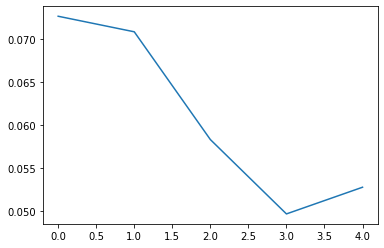

In [176]:

plt.plot(np.arange(len(losses)), losses)

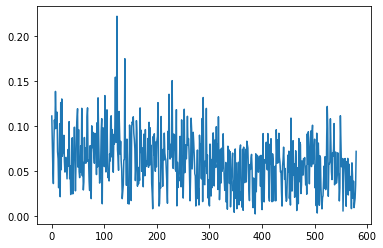

In [177]:
plt.plot(np.arange(len(bloss)), bloss)

# TEST and  Data Analysis

In [190]:
testgen,_ = get_data(itdataset,itdataset,bs=20, nsamples=itdataset.nsamples)
myit = iter(testgen)

In [191]:
test_x, y_test = next(myit)
x = test_x.type(torch.FloatTensor).cuda()
y_pred = mypredict(mymodel,x)
print("MSE {}".format(((y_test - y_pred)**2).sum()))

MSE 0.8553709387779236


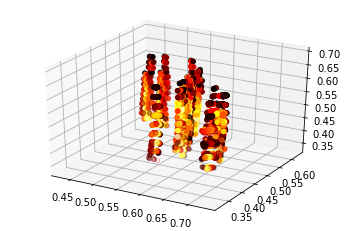

In [192]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for d in test_x:
    dx = d.cpu().numpy()
    ax.scatter(dx[:,0],dx[:,1],dx[:,2], c=dx[:,3], cmap="hot")

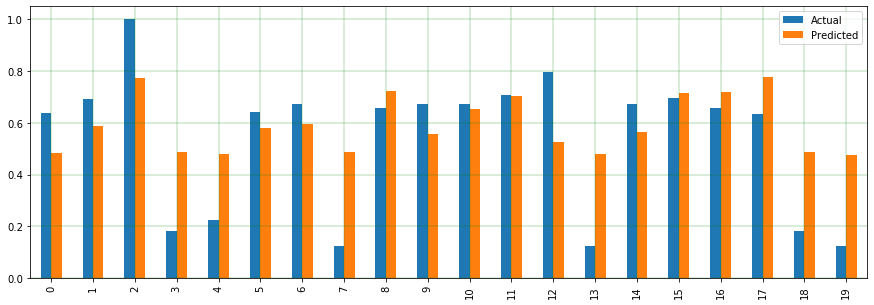

In [193]:
df2 = pd.DataFrame({'Actual': y_test.cpu().numpy().flatten(), 'Predicted': y_pred.cpu().numpy().flatten()})
df2.head()

df2.plot(kind='bar',figsize=(15,5))
plt.grid(which='major', linestyle='-', linewidth='0.3', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
plt.show()

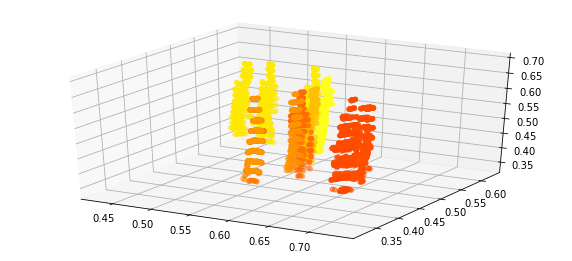

In [194]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.cm as cm

colors = cm.hot(np.linspace(0, 1, 256))

fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211, projection='3d')

for d,l in zip(test_x,y_pred):
    dx = d.cpu().numpy()
    dl = l.cpu().numpy() * np.ones(dx.shape[0])*255 
    cl = np.asarray(dl,dtype=np.uint8)
    ax.scatter(dx[:,0],dx[:,1],dx[:,2], c=colors[cl], cmap="hot")

plt.show()

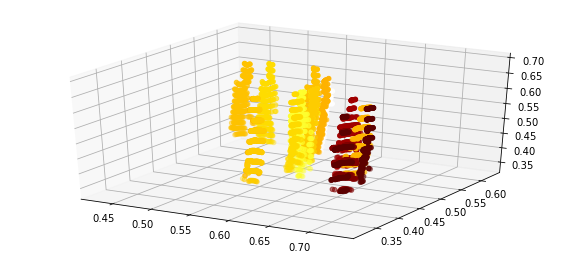

In [195]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211, projection='3d')

for d,l in zip(test_x,y_test):
    dx = d.cpu().numpy()
    dl = l.cpu().numpy() * np.ones(dx.shape[0])*255
    cl = np.asarray(dl,dtype=np.uint8)
    ax.scatter(dx[:,0],dx[:,1],dx[:,2], c=colors[cl], cmap="hot")